# **CS166 Assignment 3 - Network simulation**

Assignment instructions can be found [here](https://course-resources.minerva.kgi.edu/uploaded_files/mke/00123537-1567/cs166-assignment-3.pdf).


## **Part 0: The basic model**

In this model, we are modeling the interaction between individuals within a social network in terms of their opninion about a certain topic and how that affects the strength of their connection. There are two general rules that govern this interaction:

*   People prefer forming social relationships with others who share their preferences, opinions or interests.
* People’s preferences, opinions or interests tend to become similar to those of other people in their social circle.

We then modeled these two processes on a small­-world network (watts-strogatz graph) to see how both opinions and relationships change over time.

### **Nodes & Edges**
Each node in the graph represents an individual within the social network, and they have have an opinion attribute, which can take on values between 0 and 1. People with similar values for their opinion are in agreement on the topic and people with very different values disagree strongly. 

On the other hand, edges in the graph represents the existence of a social relationship between two people. We assign a weight to each edge, with values ranging from 0 to 1 - weight close to 0 means that the relationship between two people is weak and that those two people’s opinions do not influence each other much. A weight close to 1 means that two people have a very strong relationship and will tend to adjust their opinions to be closer to each other. 

### **Update Rules**

There are 3 rules governing the network behavior:

#### **1. People change their opinions to more closely match those of people they have a strong relationship with.**

We model this by selecting a random edge from the network — that is, two people who have an existing social relationship — and letting them interact. Think of this interaction as having a conversation about the topic on which everyone has an opinion. We update the opinion of each person to move a bit closer together. The stronger their relationship, the more they will move their opinions closer to each other.

The change in opinion of Person $i$ when talking to Person $j$ is

$\Delta o_i = \alpha w_{ij}(o_j-o_i)$

Person $j$’s opinion also changes, but in the opposite direction to Person $i$’s, thus bringing their opinions closer together. In the equation above $α ∈ (0, 0.5]$ is a parameter of the model. The larger $α$ is, the faster people change their opinions to match other people’s. The closer $α$ is to 0, the more stubborn (less likely to change their opinions) people are.


#### **2. People strengthen or weaken their relationships depending on whether they agree or disagree, respectively.**

During the same interaction as in Step 1, the weight of the edge
connecting nodes $i$ and $j$ is also changed. The change in weight is

$\Delta w_{ij} = \beta w_{ij}(1-w_{ij})(1-\gamma |o_i-o_j|)$

Here $β ∈ (0, 1)$ and $γ > 0$ are parameters of the model. If γ ≤ 1 then all weights will converge to 1 over time since differing opinions don’t matter enough to decrease edge weights. If $γ > 1$, the weight between two nodes will decrease if the opinions of the nodes
are different enough — if $|o_i - o_j| > \gamma^{-1}$.

As a final step when updating weights, we remove an edge from the network if its weight drops below 0.05. This step models a social relationship that has broken down.

#### **3. New social connections are formed between random people who are not yet connected.**

This is a relatively rare occurrence, so we do Steps 1 and 2 above 99% of the time and Step 3 only 1% of the time. Think of this process as randomly meeting someone new and forming a friendship with them. The edge weight is initially set to 0.5 in these cases. Over time the weight will increase towards 1 or decrease towards 0 depending on whether the two people have similar or differing opinions, using Steps 1 and 2.

In this first example, we will be using the following parameter values:
$α = 0.03, β = 0.3, γ = 4 $

<br/>

---



## **Loading the necessary libraries**

In [0]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
import scipy.stats as sts
import scipy

## **Building the Model**

In [0]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

## **Running the Simulation**

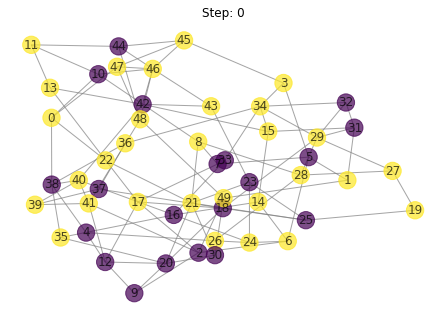

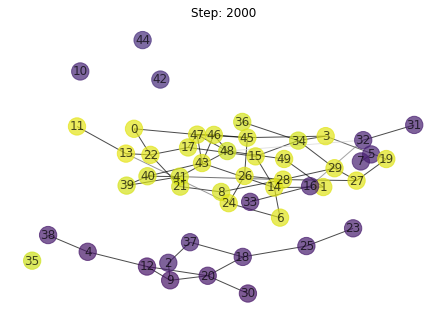

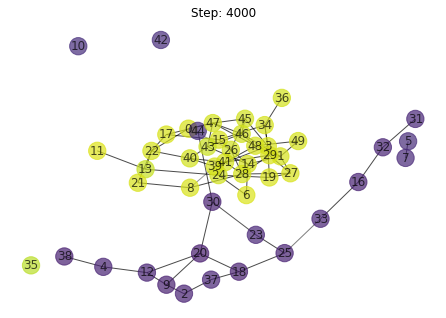

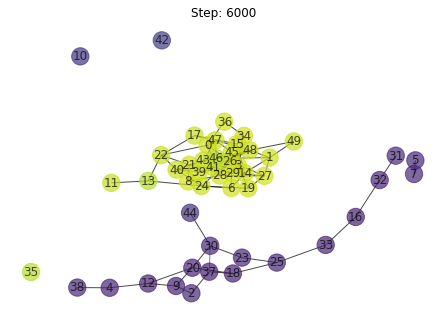

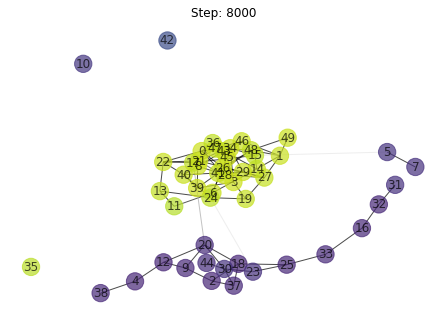

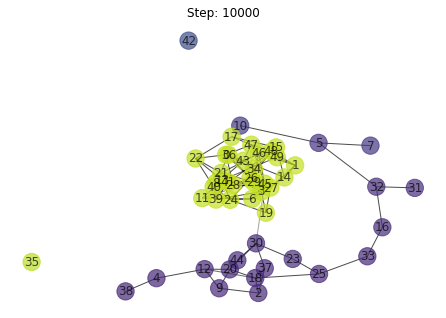

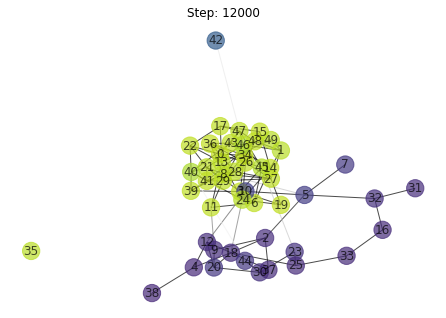

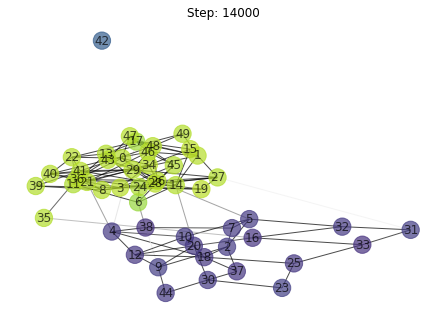

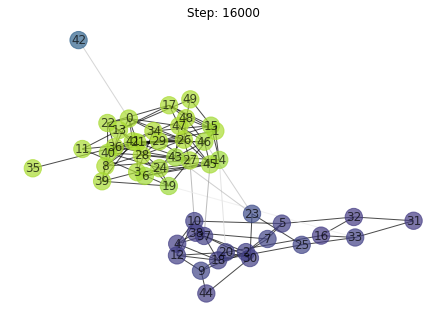

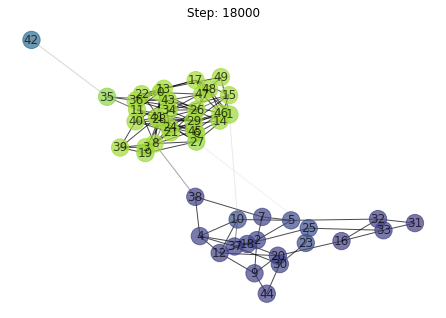

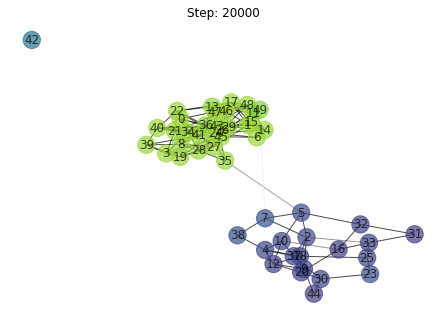

In [3]:
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()

## **Part 1: Propose 2–3 modifications**

Here, I will propose 3 ideas to modify the existing model to allow it to include the following:

*   **Multiple topics**: Each person has an opinion on multiple topics, so rather than having a single value between 0 and 1 for each opinion, I will represent it with an array of values where each entry in the array represents a person's opinion on one topic. Then, I will modify the rules of the model so that when people interact, they will select a particular topic at random and update their opinions and relationship strength based on that conversation.

*   **Forming new relationships**: I will be implementing a different mechanism for creating new relationships — new connections will only happen through introduction, which takes place 5% of the time (the remaining 95% will still be opinion and edge weight updates). How this works is we will  select a random node in the graph, check if it has more than 2 neighbors, select a random pair its neighbors and check if they are already connected; if not, we will make the connection. 

*   **Model persuasiveness**: Some people are more charismatic or convincing than others, and can, therefore, influence opinions and relationship strengths more than others. I will be adding a persuasiveness parameter for each person in the model and update the model rules to incorporate this dynamic.

# **Part 2: Local analysis**

Here's how the modifications proposed above would affect the relationship between 2 people:

*   **Multiple topics**: Since the edge weight is determined by the average of the opinions that the two individuals have on all the topics, as the number of topics increase, there's a lesser chance that their relationship will weaken. This is because much like in real life, although two people might disagree on a certain subject, there's a very low chance that they will also disagree on every other subject as well (not taking into account *ad hominem* and other form of cognitive biases here). Therefore, their bond will either stay the same or strengthen over time, depending on the values of $\beta$ and $\gamma$.

*   **Forming new relationships**: Since new connections are formed through introductory efforts made by existing connections, tthe only way either of the 2 people in this relationship can form a new connection is through each other's connections. Therefore, they are unable to form new connections with nodes that are not connected to either of them. This does not increase the relationship between these two people directly, but it does play a huge role in determining graph topography and the level of connectivity of the graph as a whole.

*   **Model persuasiveness**: Given two people, A and B, who have different levels of persuasiveness - A is a more eloquent speaker and debator, and hence has a higher level of persuasiveness, while B is not as persuasive as A. This will result in the opinion of B shifiting towards the opinion of A at a much faster rate than the opposite (opinion of A shifting towards B). As a result, this will result in a clear segregation based on opinions, which can be seen in real=life scenarios where radicalization happens and extremist groups arise. 


## **General Equations**

To see at which parameter values do opinions converge/diverge and relationship strengths increase/decrease, let's take a look at some of the general equations that we came up with earlier:


### **Opinion Change**

$\Delta o_i = \alpha w_{ij}(o_j-o_i)$

### **Edge Weight Change**

$\Delta w_{ij} = \beta w_{ij}(1-w_{ij})(1-\gamma |o_i-o_j|)$

### **Variables**
* $\alpha$: **Open-mindedness** - The larger $\alpha$ is, the faster people change their opinions to match other people’s. The closer $\alpha$ is to 0, the more stubborn (less likely to change their opinions) people are.

* $\gamma$: **Selectivity** - If the difference in opinions of the nodes are larger than $\gamma^{-1}$, then the edge weight between the two nodes will decrease; conversely, if $\gamma^{-1} \geq 1$, then the edge weights will converge to 1 since differing opinions don’t matter enough to decrease edge weights

* $\beta$: **Volatility** The rate at which edge weights are changed in response to differing opinions - changes in edge weights are more drastic at high levels of $\beta$.

Let's now take a look at how different values of $\alpha$, $\beta$ and $\gamma$ affect the rate of change of the edge weights between two nodes of different opinions:


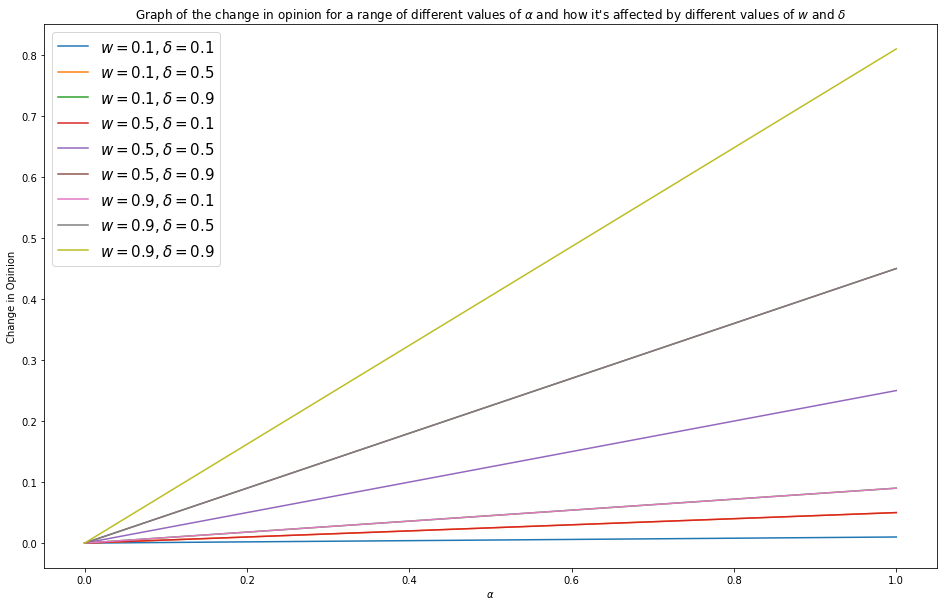

In [4]:
def opinion_change(alpha, w, delta):
    '''
    alpha: the multiplier for the rate of opinion change 
    w: the edge weight
    delta: the difference in opinions between the two nodes
    '''
    return alpha*w*delta

# Setting the values of alpha, w, and delta to be tested
alpha_vals = [i/100 for i in range(0, 101)]
w_vals = [0.1, 0.5, 0.9]
delta_vals = [0.1, 0.5, 0.9]

### Plotting a graph to compare the rate at which the changes in opinion
###  decreases/increases for different values of alpha, w and delta
plt.figure(figsize=(16,10))
plt.xlabel("$\\alpha$")
plt.ylabel("Change in Opinion")
plt.title(f"Graph of the change in opinion for a range of different values of $\\alpha$" 
            f" and how it's affected by different values of $w$ and $\\delta$")
for i in range(len(w_vals)):
  for j in range (len(delta_vals)):
    lst = [] # Creating a list to store the output of the opinion_change() 
              # function for each alpha value
    for k in range (len(alpha_vals)):
      lst.append(opinion_change(alpha_vals[k], w_vals[i], delta_vals[j]))
    # Plotting the values from the list and labeling it according to the 
    # respective w and delta values
    plt.plot(alpha_vals, lst, label = f"$w = {w_vals[i]}, \delta = {delta_vals[j]}$")
plt.legend(prop={'size': 15})
plt.show()

## **Analysis of $\alpha, \delta$ and $w$ Values**


As seen in the graph above, there is a linear positive correlation between the values of alpha and the change in the opinion values, with the yellowish-green line ($w = 0.9, \delta = 0.9$) having the steepest change for increasing values of $\alpha$. This makes sense, since the stronger the connection between two people are, even though they have a huge difference in opinion, they will still find a way to come to a compromise, and an effective way to do that is to change their own opinions to fit the other person's perspective. Therefore, if their initial opinion difference is large, they will have a huge room for change, and therefore the rate of change will be the steepest. 

Conversely, when both the $w$ and $\alpha$ values are low, (blue line, $w = 0.1, \delta = 0.1$) the rate of change in opinion is almost negligible for increasing values of $\alpha$. This makes sense, since the weaker the connection between two people are, they wouldn't make an effort to change their opinions to fit the other person's perspective, not to mention the fact that they have a minute opinion difference to begin with anyways. 

Also, we notice that for low values of $w$ and high values of $\alpha$ (green line) as well as the opposite (pink line), the rate of change of the opinions for increasing values of $\alpha$ is almost idential. This tells us that a close friend with whom we have a tiny opinion difference will change our opinion as much as a not-so-close acquaintance with a huge opinion difference.


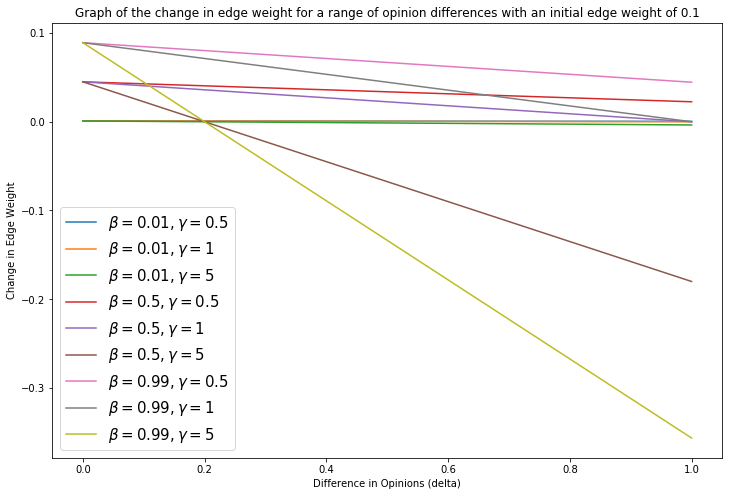

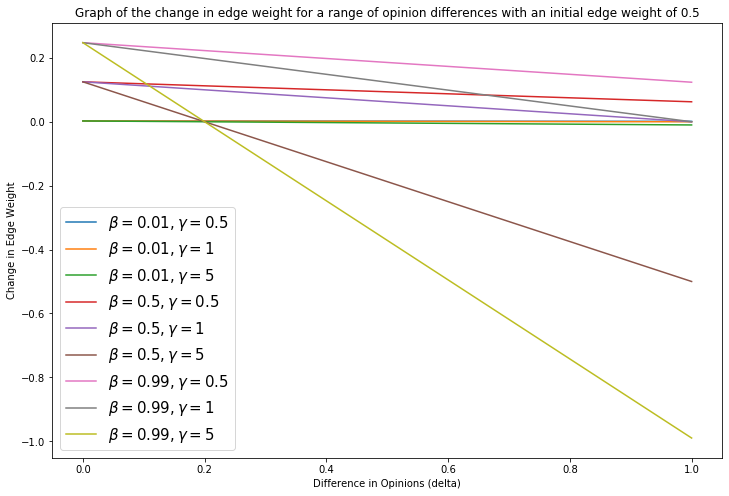

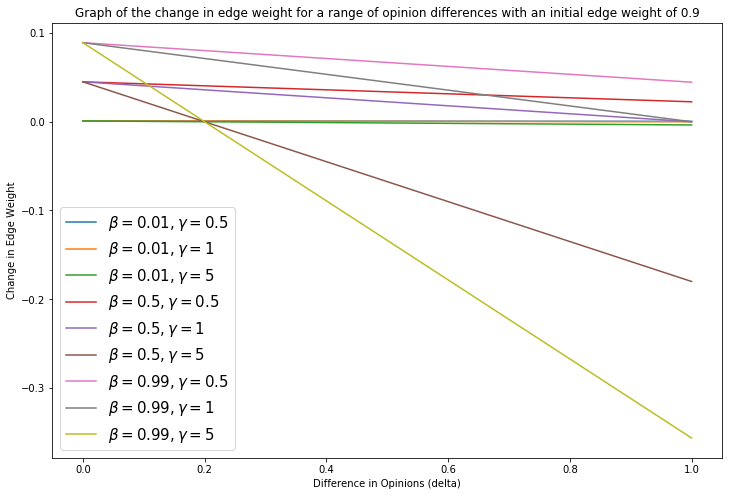

In [5]:
def edge_weight_change(w, beta, gamma, delta):
    '''
    w: the initial edge weight
    beta: the rate of change
    gamma: the pickiness of the nodes
    delta: the difference in opinions between the two nodes
    '''
    return beta*w*(1-w)*(1-gamma*abs(delta))

# Setting the values of beta, gamma, and delta to be tested
beta_vals = [0.01, 0.5, 0.99]
gamma_vals = [0.5, 1, 5]
delta_vals = [i/100 for i in range(0, 101)]

def plot_edge_weight_change(w):
    '''
    Function to plot the charts to compare the rate at which the changes in edge
    weight decreases/increases for different values of beta, gamma and delta
    '''
    plt.figure(figsize=(12,8))
    plt.xlabel("Difference in Opinions (delta)")
    plt.ylabel("Change in Edge Weight")
    plt.title(f"Graph of the change in edge weight for a range of opinion differences" 
                f" with an initial edge weight of {w}")
    for i in range(len(beta_vals)):
      for j in range (len(gamma_vals)):
        lst = [] # Creating a list to store the output of the edge_weight_change() 
                 # function for each delta value
        for k in range (len(delta_vals)):
          lst.append(edge_weight_change(w, beta_vals[i], gamma_vals[j], delta_vals[k]))
        # Plotting the values from the list and labeling it according to the respective beta
        # and gamma values
        plt.plot(delta_vals, lst, label = f"$\\beta = {beta_vals[i]}, \gamma = {gamma_vals[j]}$")
    plt.legend(prop={'size': 15})
    plt.show()

# Repeating for different values of w (initial edge weight)
plot_edge_weight_change(0.1)
plot_edge_weight_change(0.5)
plot_edge_weight_change(0.9)

## **Analysis of $\beta$ and $\gamma$ Values**

As seen in all three of the graphs above, when both $\beta$ and $\gamma$ have high values (yellowish-green line, $\beta=0.99$ $\gamma=5$), the change in edge weight decreases at the fastest rate, resulting in the steepest slope. This makes sense, since a high $\beta$ will give us a high rate of change in the edge weights, while a high $\gamma$ means that $\gamma^{-1}$ is smaller and hence the the edge weights will decrease at a faster rate. 

However, to understand which one of the two values - $\beta$ and $\gamma$ - has a stronger effect on the rate at which the change in edge weights decreases, let's hold one of the two values constant and analyze how the other value affects the results. Firstly, we notice that different levels of $\beta$ will result in different initial changes in edge weights: 

*   At a low $\beta$ value ($\beta=0.01$, lines blue, orange and green), the change in edge weight stays constant throughout the course, no matter how big the difference in opinions is. This makes sense, since $\beta$ is literally the rate at which edge weights changes, therefore at an extremely low $\beta$, the rate of change is so miniscule that it is essentially negligible.
*   At a high $\beta$ value ($\beta=0.99$, lines pink, gray and yellowish-green), the initial change in edge weight is the highest, but also decreases at the fastest rate compared to other values of $\beta$. This makes sense, since a high $\beta$ means that the rate at which edge weights changes is high as well.
*   At a medium $\beta$ value ($\beta=0.5$, lines red, purple and brown), the initial change in edge weight is lower than a high $\beta$ value but higher than a low $\beta$ value. The rate of decrease of the change in edge weights is slower than that of a high $\beta$ value, which makes sense, since the rate at which edge weights changes is directly proportional to the $\beta$ value.

On the other hand, different levels of $\gamma$ will affect how quickly the changes in edge weight decreases for increasing levels of opinion difference:

*   At a low $\gamma$ value ($\gamma=0.5$, lines blue, red and pink), the change in edge weight decreases at the slowest rate. This makes sense, since a low $\gamma$  means that the difference in opinion between the two nodes will most likely be smaller than $\gamma^{-1}$, and the smaller it is relative to $\gamma^{-1}$, the slower the rate of decrease of the edge weight changes. Also, since $\gamma \leq 1$, all weights will converge to 1 over time because differing opinions don’t matter enough to decrease edge weights.

*   At a medium $\gamma$ value ($\gamma=1$, lines orange, purple and gray), the change in edge weight decreases at a faster rate than low $\gamma$ values. Nonetheless, since $\gamma$ is still $\leq 1$, all weights will converge to 1 over time because differing opinions don’t matter enough to decrease edge weights.

*   At a high $\gamma$ value ($\gamma=5$, lines green, brown and yellowish-green),  the change in edge weight decreases at the highest rate. This makes sense, since a high $\gamma$  means that the difference in opinion between the two nodes will most likely be bigger than $\gamma^{-1}$, and the bigger it is relative to $\gamma^{-1}$, the faster the rate of decrease of the edge weight changes.


## **Analysis of the Value of $w$ - Initial Weight of the Edges**

As you see from the graph above, the rate at which the change in edge weight decreases is the highest when $w=0.5$, as opposed to when $w=0.1$ or $w=0.9$ for all $\beta$ and $\gamma$ values. This tells us that when the strength of the bond between two people is at an average level, they will have a higher potential to experience a change in the bond strength. Conversely, when the stregnth of the bond between two people are either very strong or very weak. there is a lower potential to experience any changes in the bond strength. In a real-world context, this translates to the one of the two following scenarios:

* We have a very strong bond with our closest friends that is not likely to change despite any differences in opinions that we might have

* We are not close enough to our acquiantances and therefore will not be able to increase the relationship strength that easily.


## **Selecting appropriate $\alpha, \beta, \gamma$ and $w$ values for implementation**

From above, we notice that the values of $\alpha, \beta, \gamma$ and $w$ are crucial in determining the eventual output of the simulation. Therefore, we will be keeping the value of $\alpha$ at a relatively low value of 0.03 (but this is amplified for scenarios where there are varying levels of persuasiveness), $\beta$ to be a moderate value of 0.3, since we don't want the edge weight to change too quickly. We will be using a $\gamma$ value that is larger than 1 - at 4, which will give us the appropriate level of selectiveness, while the initial node weight, $w$ will just be in the middle, 0.5.


## **The Persuasion Factor**

In the third modified scenario mentioned above, we will be adding a persuasion factor to each individual that has a default value of 1. This persuasion factor,let's call it $p$, will have a range of values between 0.5 and 1.5 (we will sample that from a uniform distribution when assigning the persuasion factor to each node). 

The addition of the persuasion factor changes our initial equation that models opinion change from $\Delta o_i = \alpha w_{ij}(o_j - o_i)$, to $\Delta o_i = p_j\alpha_i w_{ij}(o_j - o_i)$. In this case, to model the change in opinion of a node $o_i$, we will take into consideration the persuasion factor of its neighbor node, $p_j$. 

To understand this further, let's plot the graph for the change in opinion weight at increasing levels of $p$ at our chosen $alpha$ value of 0.03:



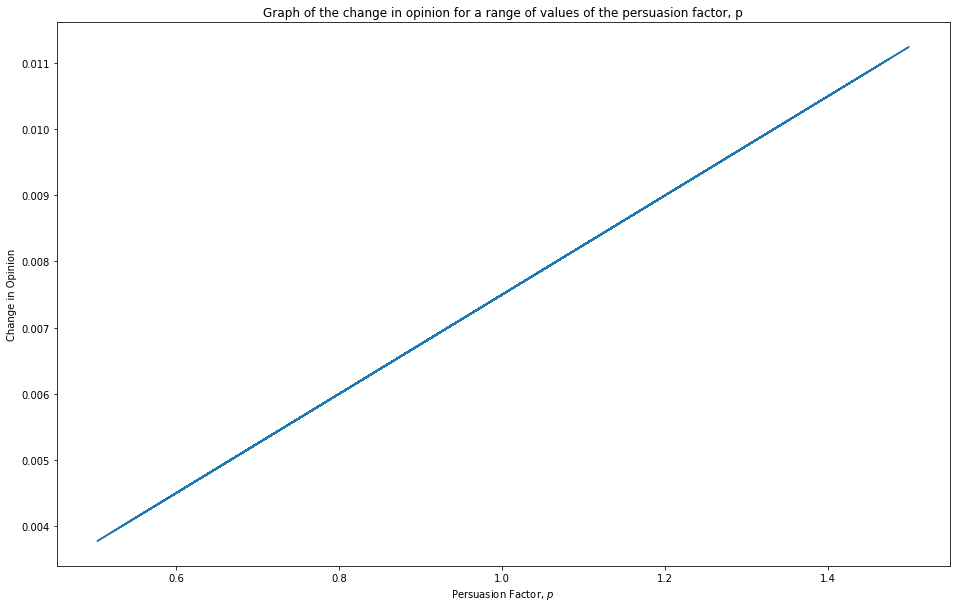

In [6]:
def opinion_change_persuasion(p, alpha, w, delta):
    '''
    p: the persuasion factor
    alpha: the multiplier for the rate of opinion change 
    w: the edge weight
    delta: the difference in opinions between the two nodes
    '''
    return p*alpha*w*delta

# Setting the values of alpha, w, and delta to be tested
p_vals = [random.uniform(0.5, 1.5) for _ in range(100)]
alpha_val = 0.03
w_val = 0.5
delta_val = 0.5

### Plotting a graph to compare the rate at which the changes in opinion
###  decreases/increases for different values of alpha, w and delta
plt.figure(figsize=(16,10))
plt.xlabel("Persuasion Factor, $p$")
plt.ylabel("Change in Opinion")
plt.title(f"Graph of the change in opinion for a range of values of the persuasion factor, p")
p_lst = [] # Creating a list to store the output of the opinion_change() 
              # function for each value of p
for i in range(len(p_vals)):
    p_lst.append(opinion_change_persuasion(p_vals[i], alpha_val, w_val, delta_val))
    # Plotting the values from the list and labeling it according to the 
    # respective w and delta values
plt.plot(p_vals, p_lst)
plt.show()

As seen from the graph above, the magnitude of the change in opinion increases linearly as the persuasion factor increases, which makes sense, since the more persuasive you are, the more likely you are able to convince your friend to change their opinion to match yours. 

In our modified model below, I will be assigning the persuasion factor in such a way that node has an equal chance of having a persuasian factor between 0.5 and 1.5 (``random.uniform(0.5, 1.5)``).

# **Vector Field Analysis**

By plotting out the vector fields for each of the different conditions stated above, we can observe if there are any convergence or divergence for different values of opinion and edge weights.



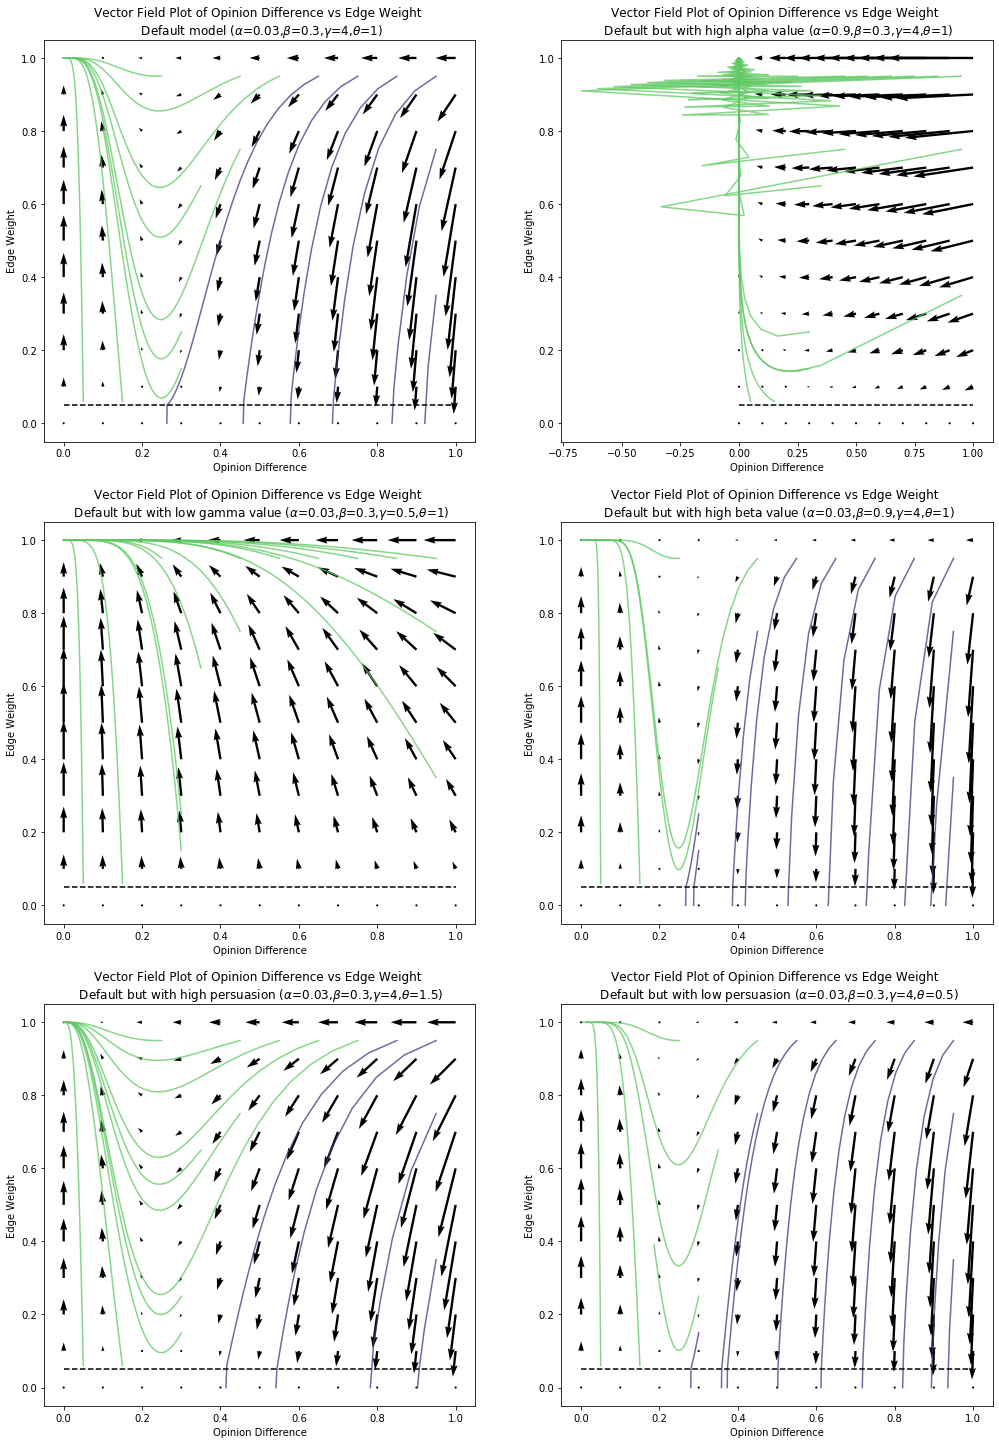

In [7]:
def vector_plot(alpha,beta,gamma,theta,title_desc='',title_params=''):

    # Plot traces of how opinion and weight change over time
    for opinion, weight in [
        [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
        [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
        [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
    ]:
        ow = [[opinion, 0.0, weight]]
        for i in range(100):
            delta_o = theta * alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight])
        plt.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

    # Plot vector field
    opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0] * theta
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

    plt.title(f"Vector Field Plot of Opinion Difference vs Edge Weight \n {title_desc} {title_params}")
    plt.xlabel('Opinion Difference')
    plt.ylabel('Edge Weight')
    plt.plot([0, 1], [0.05, 0.05], 'k--')


param_pairs = [
    ((0.03,0.3,4,1), 'Default model'),
    ((0.9,0.3,4,1), 'Default but with high alpha value'),
    ((0.03,0.3,0.5,1), 'Default but with low gamma value'),
    ((0.03,0.9,4,1), 'Default but with high beta value'),
    ((0.03,0.3,4,1.5), 'Default but with high persuasion'),
    ((0.03,0.3,4,0.5), 'Default but with low persuasion')
]

plt.figure(figsize=(17, 34))
cmap = plt.cm.viridis  # good for color blindness

for i in range(len(param_pairs)):
    plt.subplot(4,2,i+1)
    vector_plot(alpha=param_pairs[i][0][0],
                beta=param_pairs[i][0][1],
                gamma=param_pairs[i][0][2],
                theta=param_pairs[i][0][3],
                title_desc=f'{param_pairs[i][1]}',
                title_params=f'($\\alpha$={param_pairs[i][0][0]},' 
                f'$\\beta$={param_pairs[i][0][1]},'
                f'$\gamma$={param_pairs[i][0][2]},' 
                f'$\\theta$={param_pairs[i][0][3]})')

## **Analysis**

Here, I will be analyzing the vector field plots and determine for which opinion and relationship strength values will clusters form or split apart in the simulation.

### **Default Model**

In the default model, we notice that the opinion difference tends to converge to 0 when the edge weight is at a maximum level of 1. This means that in an ideal world, people with ultra-strong, 100% foolproof bonds will find a way to come to terms about their differences and will end up with no opinion difference at all. However, when the edge weight values are lower than 1, the edge weights will tend towards zero for opinion diferences of 0.4 to 1. This means that people's relationships will begin to weaken if they do not find a compromise for their dissenting opoinions, and will eventually deteriorate to a certain point (in this case, it's 0.05) where the relationship is unsalvageable. We also notice a tipping point when the opinion difference is at 0.3, where the edge weight will start increasing again for any opinion difference values below 0.3. To relate this to a real-life context, we can imagine when our opinion difference with someone is close to 0, this means that we have very similar mindsets and thus, forming a relationship will be really easy. 

### **Default Model but with High Alpha Values**

In this modification, we notice that for a model that has a high alpha value, the opinion differences tend to converge towards 0 for all edge weight values. Since alpha represents the rate at which nodes adjust their opinions to match neighboring nodes' opinions during interactions, when alpha is very high, the nodes will reduce their opinion differences in such a fast rate that there is no time for their edge weight to decrease. Nontheless, it is noticeable that at lower edge weight values, the arrows seem to be leaning more towards the x-axis but none actually go that way. This means that if people are more open-minded, relationships will not be broken that easily. Therefore, the graph will be much more connected at the end of the day, and there will not be too many isolated clusters forming.

### **Default Model but with Low Gamma Values**

For this model, we can see that while the edge weight is converging towards 1, the opinion difference converges to 0. This makes sense, since gamma represents the sensitivity of each node to another node with dissenting opinions. Therefore, at really high gamma values, nodes tend to reduce their opinion differences whilst also trying to increase and maximize their edge weights. This simulates a utopic society where everyone is super diplomatic and wants to form strong relationships with everybody. They also have a "fit in" mindset where if they encounter another person with a dissenting opinion, they will try their best to fit into the other person's paradigm without breaking the relationship. Therefore, the graph will be much more connected at the end of the day, and there will not be too many isolated clusters forming.

### **Default Model but with High Beta Values**

This is similar to the vector field for the default model, but with the edge weights will converging towards zero for opinion differences of 0.4 and above at a much faster rate than that of the default model. This makes sense, since beta represents the volatility of the connection, and thus at a high beta value, the bonds are much easily broken whenever the opinion difference surpasses a certain threshold. This simulates a scenario where people are super sensitive and whenever they find themselves at a disagreement with another person, their first instinct is to consider breaking the relationship. Therefore, the graph will be much less connected at the end of the day, and we will notice the formation of many isolated clusters.

### **Default Model but with High Persuasion**

This model is also similar to the original default model, but with the edge weight converging towards 0 at a slightly slower rate for opinion differences of 0.4 and above. This means that by the time their relationship breaks, their opinion difference will be smaller than that of their counterparts in the default model. This makes sense because with a higher level of persuasion, people will tend to be able to convince other people to believe in their side of the story more effectively and therefore sway the other person's stance more. Therefore, the graph will be slightly more connected at the end of the day, and there will not be too many isolated clusters forming.

### **Default Model but with Low Persuasion**

This model is also similar to the original default model, but in contrast to the high persuasion model, the edge weights tend to converge towards 0 at a slightly faster rate for opinion differences of 0.4 and above. This means that by the time their relationship breaks, their opinion difference will be larger than that of their counterparts in the default model. This makes sense because with a lower level of persuasion, people will tend not to be able to convince other people to believe in their side of the story as effectively and therefore will not be able to sway the other person's stance as much. Therefore, the graph will also be slightly more connected at the end of the day, and there will not be too many isolated clusters forming.



#**Part 3: Implementation**

For this part, I will be using the Watts Strogatz graph because of its small-world properties. In other words, the number of edges per node follow a power-law distribution, as more central nodes (nodes with more connections) tend to receive even more new connections compared to peripheral nodes. This is a very accurate representation of society, since differnet people tend to have different levels of popularity, and therefore this graph is an appropriate choice to simulate the evolution in dynamics in a real-world context.

In my implementation below, I will be including 4 different situations: 

* The default update settings identical to the one above
* The presence of multiple topics instead of a singular topic
* New connections are formed via introduction and not randomly
* There are varying levels of persuasiveness for each node 




In [0]:
class NewSocialDynamicsSimulation:
    '''
    Modifying the original SocialDynamicsSimulation code to include the 3 
    modifications suggested in part 1.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4, multiTopics=False, 
                 numTopics=3, intro=False, persuasion=False, persuadeParam=1):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.

            multiTopics (bool) To account for scenarios where there are multiple
              topics involved instead of just a single topic.

            numTopics (int) The number of topics for when there are multiple
              topics involved
            
            intro (bool) To account for scenarios where new connections are not
              formed randomly but rather through introductions - simulating a
              situation like LinkedIn, where people can get introduced to 2nd
              connections if they both share a mutual connection

            persuasion (bool) To account for scenarios where people have varying
              levels of persuasiveness. 

            persuadeParam (float) The persuasive parameter for each individual. 
              The default value for this is 1, and in scenarios where there are
              varying levels of persuasiveness, it can range from 0.5 to 1.5.

        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.multiTopics = multiTopics
        self.numTopics = numTopics
        self.intro = intro
        self.persuasion = persuasion
        self.persuadeParam = persuadeParam

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)

        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5

        for node in self.graph.nodes:
          if self.multiTopics: # If there are multiple topics, assign a list of random floats 
                               # to each node that will represent the nodes opinion on each 
                               # of those topics
            self.graph.nodes[node]['opinion'] = [random.random() for _ in range(self.numTopics)]
          else: # Else, just p
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
          if self.persuasion: # If persuasion mode is on, assign random values between
                              # 0.5 and 1.5 as to each node as their persuasion parameter
            self.graph.nodes[node]['persuadeParam'] = random.uniform(0.5, 1.5)
          else:  # Else, just set their persuasion parameter to the preset value of 1
            self.graph.nodes[node]['persuadeParam'] = self.persuadeParam

        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            # Since we are including scenarios where there might be multiple
            # topics involved, we will have to find the mean of each node's 
            # opinions for each topic.
            node_color=[np.mean(self.graph.nodes[i]['opinion']) for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
      '''
      In this update step, we will be accounting for the following scenarios:
      - Default update settings
      - Presence of multiple topics 
      - New connections from via introduction and not randomly
      - Varying levels of persuasiveness for each node 
      '''
      # If new connections are formed through introductions which happen 5% of the time
      if self.intro and random.uniform(0, 1) < 0.05: 
          nodes = list(self.graph.nodes)
          for node in nodes:
            neighbors = list(self.graph.neighbors(node))
            if len(neighbors) > 2:
              new_edge = random.sample(neighbors, 2)
              if new_edge not in self.graph.edges:
                 # Form a new connection between the two nodes that has a random weight that 
                 # is sampled from a normal distribution of mean 0.5 and stdev 0.1
                self.graph.add_edge(new_edge[0], new_edge[1], weight=np.random.normal(0.5, 0.1))
                break

      # If new connections are formed randomly and will only happen 1% of the time
      if not self.intro and random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
          nodes = list(self.graph.nodes)
          while True:
              new_edge = random.sample(nodes, 2)
              if new_edge not in self.graph.edges:
                  break
          self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
      else:
          # Select a random edge and update node opinions and edge weight
          edge = random.choice(list(self.graph.edges))
          weight = self.graph.edges[edge]['weight']
          opinions = [self.graph.nodes[n]['opinion'] for n in edge]
          if self.multiTopics: # For scenarios where there are more than one topic
            t = random.randint(0, self.numTopics - 1) # Select a random topic from list of topics
            for i in [0, 1]:
                # Determining the persuasiveness of the other node that the current
                # node is interacting with and using that as their persuade parameter
                persuasiveness = self.graph.nodes[edge[abs(i-1)]]['persuadeParam']
                # Determine the change in opinion with the formula given above
                self.graph.nodes[edge[i]]['opinion'][t] = (opinions[i][t] + persuasiveness * 
                                  self.alpha * weight * (opinions[1-i][t] - opinions[i][t]))
            # Updating the weight of the edge between the two nodes with the formula
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0][t] - opinions[1][t])))
          else: # For scenarios where there is only one topic
            for i in [0, 1]: 
                persuasiveness = self.graph.nodes[edge[abs(i-1)]]['persuadeParam']
                self.graph.nodes[edge[i]]['opinion'] = (opinions[i] + persuasiveness * 
                                  self.alpha * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
          
          # Remove very weak connections
          if self.graph.edges[edge]['weight'] < 0.05:
              self.graph.remove_edge(*edge)
      self.step += 1
    
    def averageConnectivity(self): 
      '''
      Function to calculate the average number of connections that
      each node in the graph has
      '''
      connectionsList = []
      nodes = list(self.graph.nodes) 
      for node in nodes: # Iterating across the list of nodes and
                         # appending the number of neighbors that each
                         # node has to the list
        connectionsList.append(len(list(self.graph.neighbors(node))))
      return np.mean(connectionsList) # Get the mean of the list

    def percentageDisconnect(self):
      '''
      Function to calculate the percentage of nodes in the graph that
      has no edges attached to them (disconnected)
      '''
      counter = 0
      nodes = list(self.graph.nodes)
      for node in nodes: # Iterating across the list of nodes and whenever
                         # it encounters a node that has no neighbors, the
                         # counter incresaes by 1
        if len(list(self.graph.neighbors(node))) == 0:
          counter += 1
      return counter/len(nodes) * 100 # Divide by 100 to get the percentage

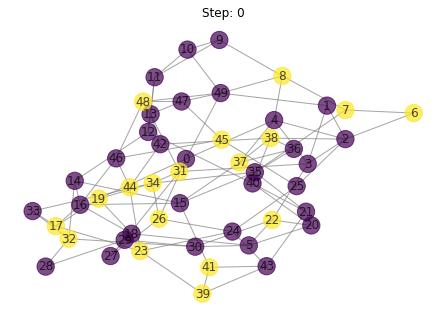

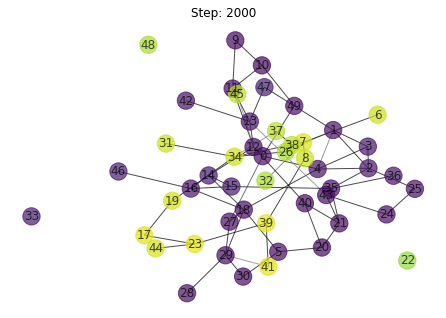

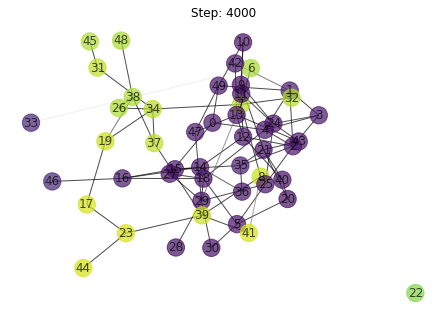

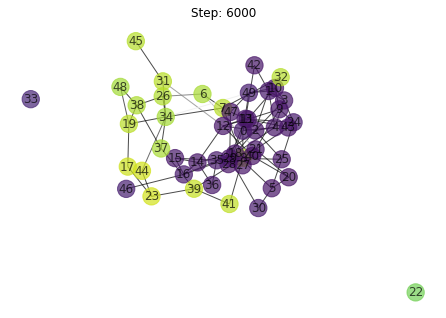

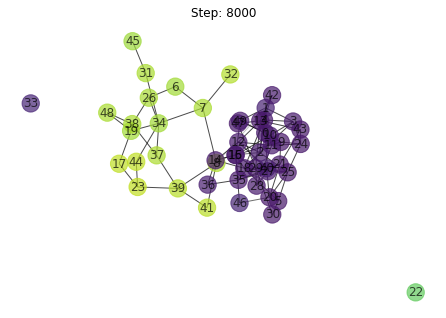

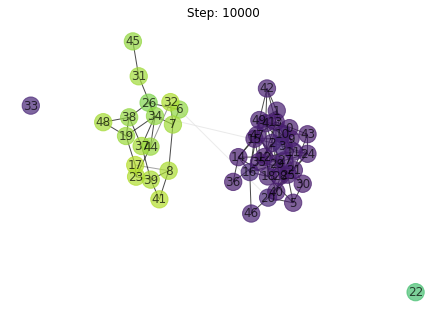

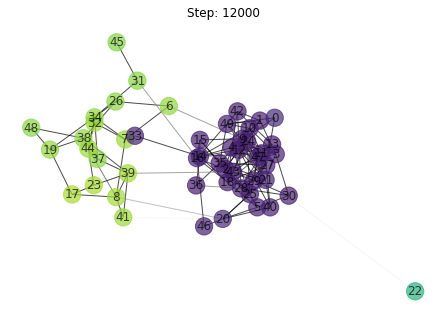

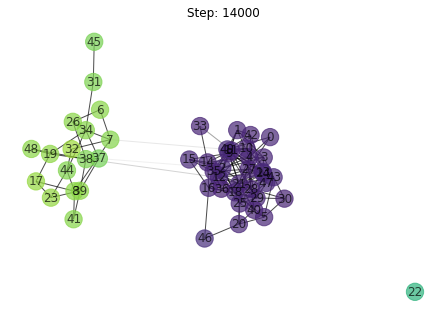

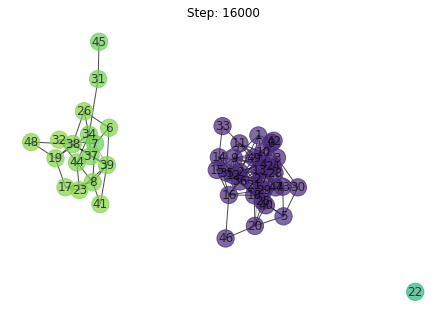

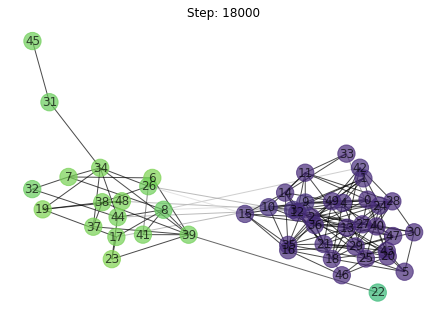

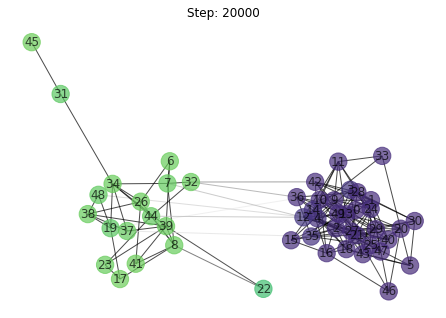

In [9]:
'''
Default update settings
'''
default = NewSocialDynamicsSimulation()

# Creating a list to store the average connectivity of the nodes in
# the graph at every stage
default_ave_connectivity = [] 

# Creating a list to store the percentage of nodes that got
# disconnected at every stage of the graph
default_disconnect = []

default.initialize() # Initializing the simulation 

# Count the average connectivity in the beginning
default_ave_connectivity.append(default.averageConnectivity())
default_disconnect.append(default.percentageDisconnect())
plt.figure()
default.observe()

# Run the simulation 2000 times and make an observation every 200 times
for i in range(10):
    for i in range(2000):
        default.update()
    default_ave_connectivity.append(default.averageConnectivity())
    default_disconnect.append(default.percentageDisconnect())
    plt.figure()
    default.observe()

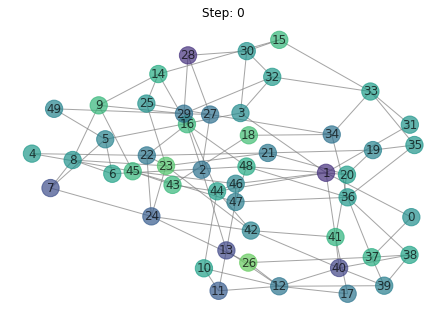

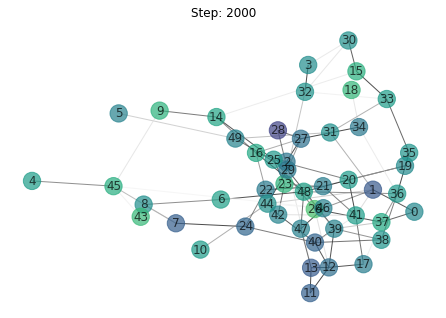

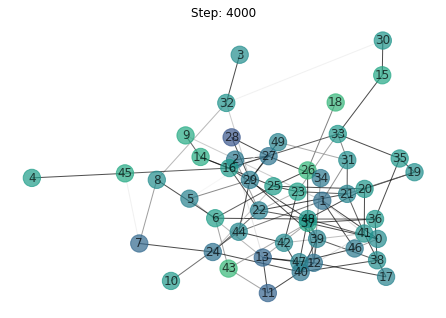

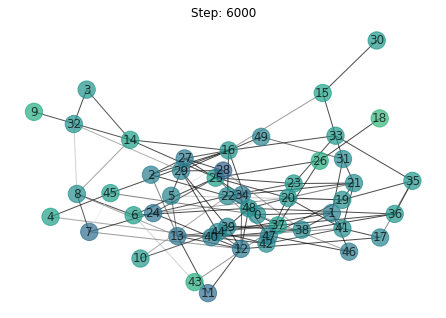

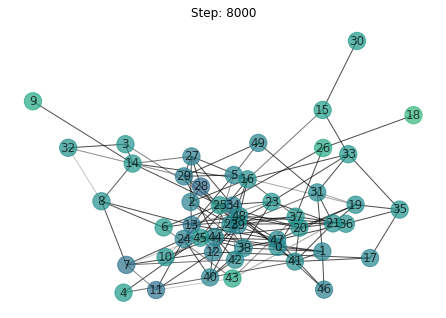

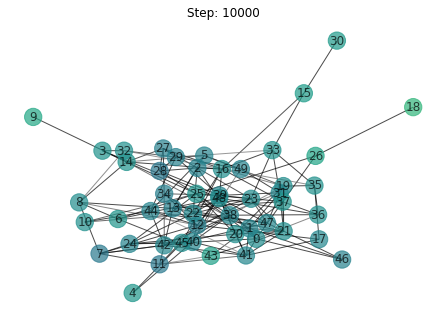

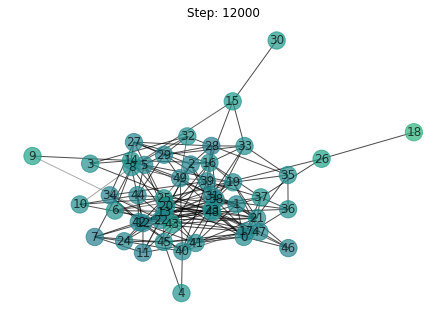

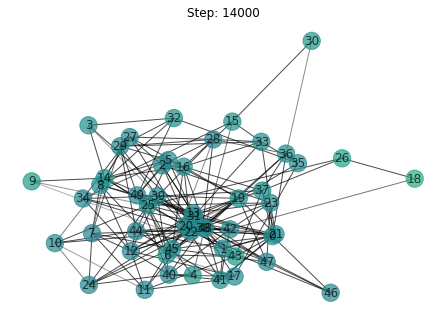

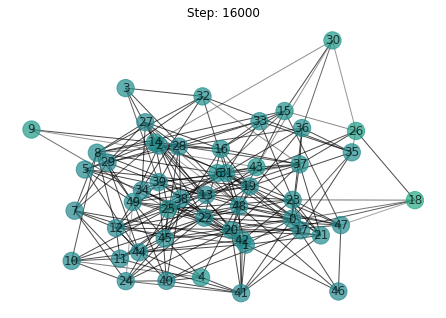

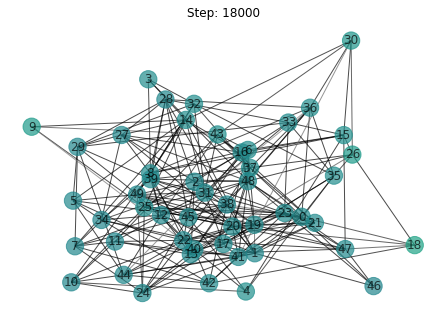

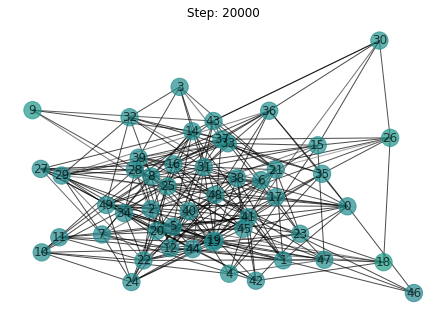

In [10]:
'''
Presence of multiple topics
'''
multipleTopics = NewSocialDynamicsSimulation(multiTopics=True)

# Creating a list to store the average connectivity of the nodes in
# the graph at every stage
multiTopics_ave_connectivity = [] 

# Creating a list to store the percentage of nodes that got
# disconnected at every stage of the graph
multiTopics_disconnect = []

multipleTopics.initialize() # Initializing the simulation 

# Count the average connectivity in the beginning
multiTopics_ave_connectivity.append(multipleTopics.averageConnectivity())
multiTopics_disconnect.append(multipleTopics.percentageDisconnect())
plt.figure()
multipleTopics.observe()

# Run the simulation 2000 times and make an observation every 200 times
for i in range(10):
    for i in range(2000):
        multipleTopics.update()
    multiTopics_ave_connectivity.append(multipleTopics.averageConnectivity())
    multiTopics_disconnect.append(multipleTopics.percentageDisconnect())
    plt.figure()
    multipleTopics.observe()

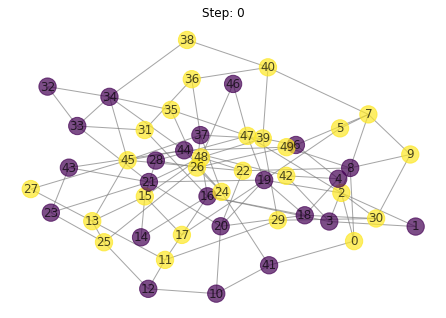

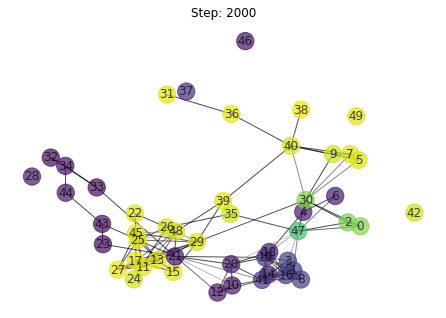

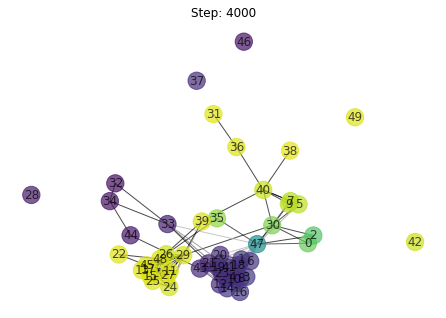

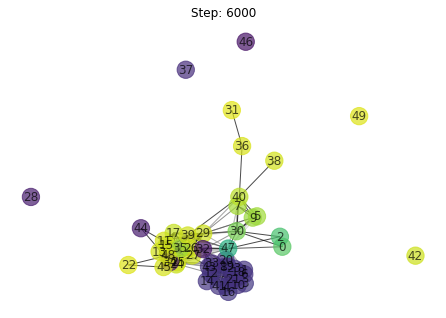

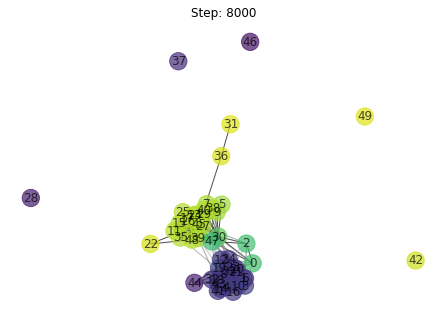

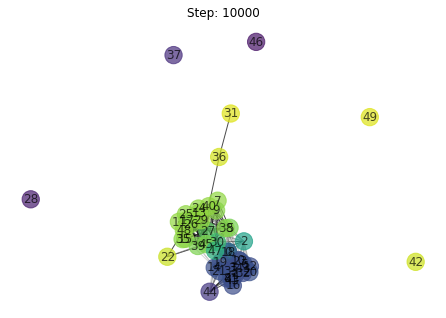

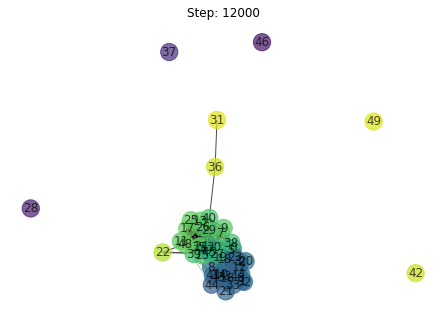

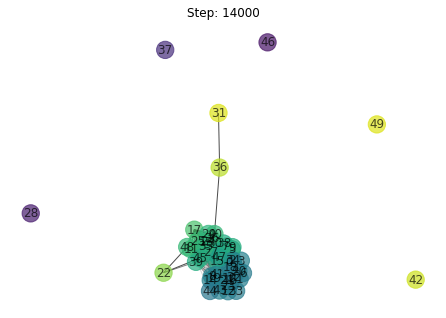

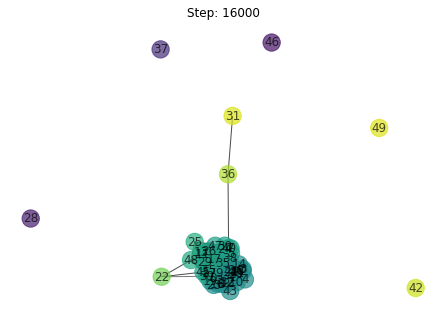

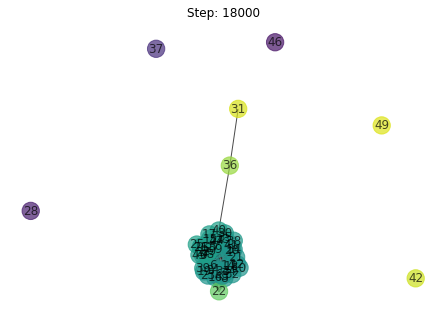

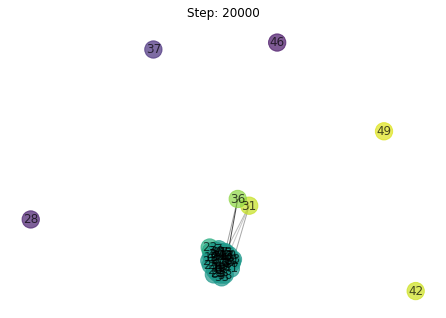

In [11]:
'''
New connections are formed through introduction and not randomly
'''
introduction = NewSocialDynamicsSimulation(intro=True)

# Creating a list to store the average connectivity of the nodes in
# the graph at every stage
introduction_ave_connectivity = [] 

# Creating a list to store the percentage of nodes that got
# disconnected at every stage of the graph
introduction_disconnect = []

introduction.initialize() # Initializing the simulation 

# Count the average connectivity in the beginning
introduction_ave_connectivity.append(introduction.averageConnectivity())
introduction_disconnect.append(introduction.percentageDisconnect())
plt.figure()
introduction.observe()

# Run the simulation 2000 times and make an observation every 200 times
for i in range(10):
    for i in range(2000):
        introduction.update()
    introduction_ave_connectivity.append(introduction.averageConnectivity())
    introduction_disconnect.append(introduction.percentageDisconnect())
    plt.figure()
    introduction.observe()

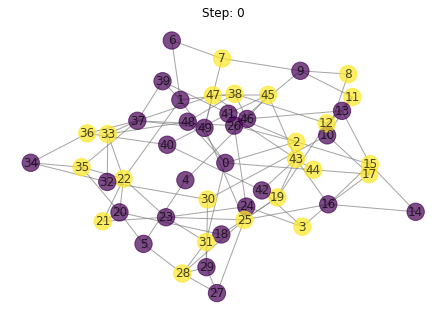

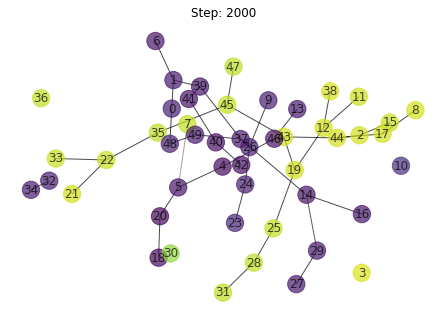

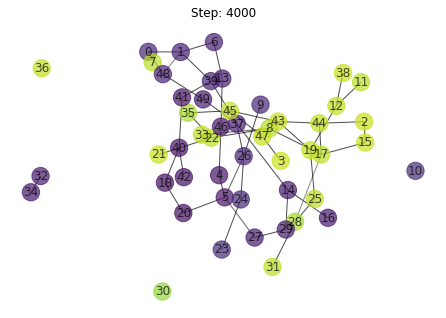

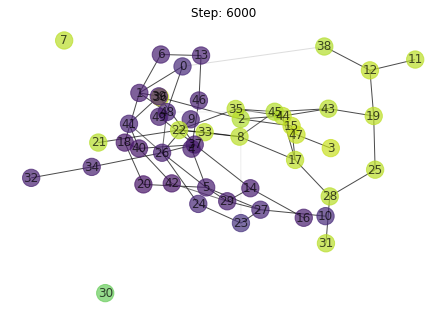

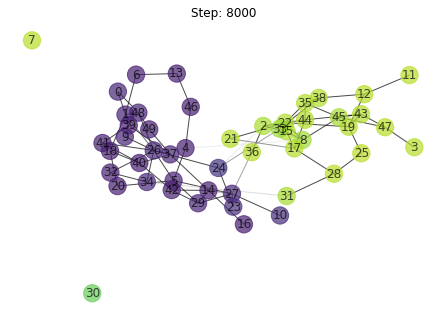

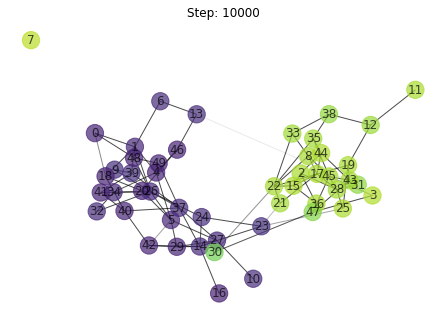

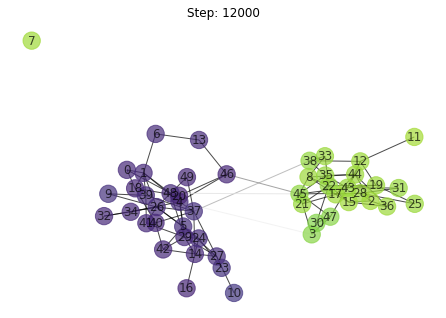

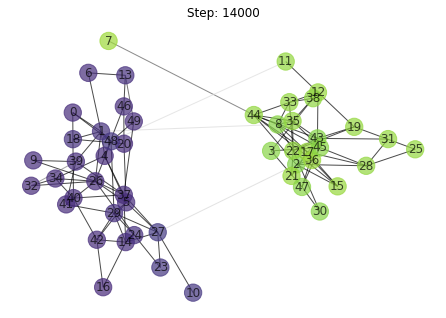

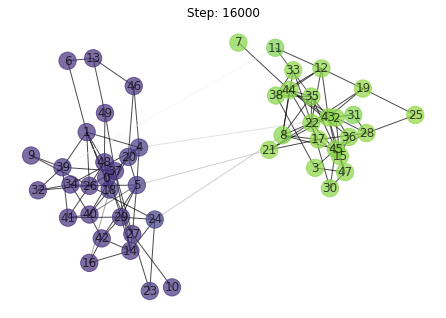

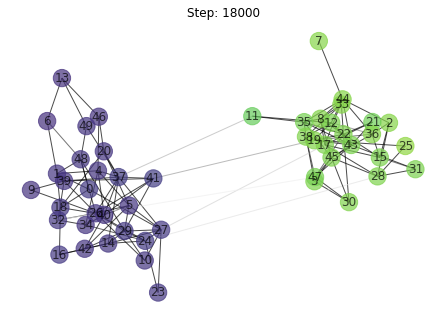

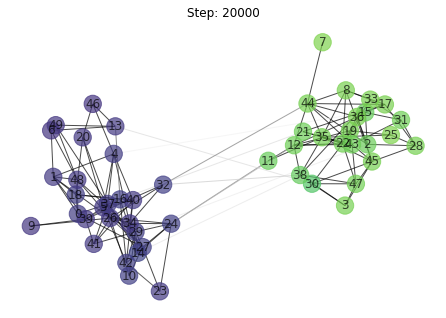

In [12]:
'''
There are varying levels of persuasion for each node
'''
uniquePersuasion = NewSocialDynamicsSimulation(persuasion=True)

# Creating a list to store the average connectivity of the nodes in
# the graph at every stage
uniquePersuasion_ave_connectivity = [] 

# Creating a list to store the percentage of nodes that got
# disconnected at every stage of the graph
uniquePersuasion_disconnect = []

uniquePersuasion.initialize() # Initializing the simulation 

# Count the average connectivity in the beginning
uniquePersuasion_ave_connectivity.append(uniquePersuasion.averageConnectivity())
uniquePersuasion_disconnect.append(uniquePersuasion.percentageDisconnect())
plt.figure()
uniquePersuasion.observe()

# Run the simulation 2000 times and make an observation every 200 times
for i in range(10):
    for i in range(2000):
        uniquePersuasion.update()
    uniquePersuasion_ave_connectivity.append(uniquePersuasion.averageConnectivity())
    uniquePersuasion_disconnect.append(uniquePersuasion.percentageDisconnect())
    plt.figure()
    uniquePersuasion.observe()

# **Part 4: Analysis**

Here, I will be analyzing the simulation results and determine under what conditions do social clusters form and under what conditions do they split apart. I will also be reporting on whether and how my simulations show patterns observed in real life

To do that, let me plot a graph that shows the average number of connections per node as the time passes for each of the 4 models above:

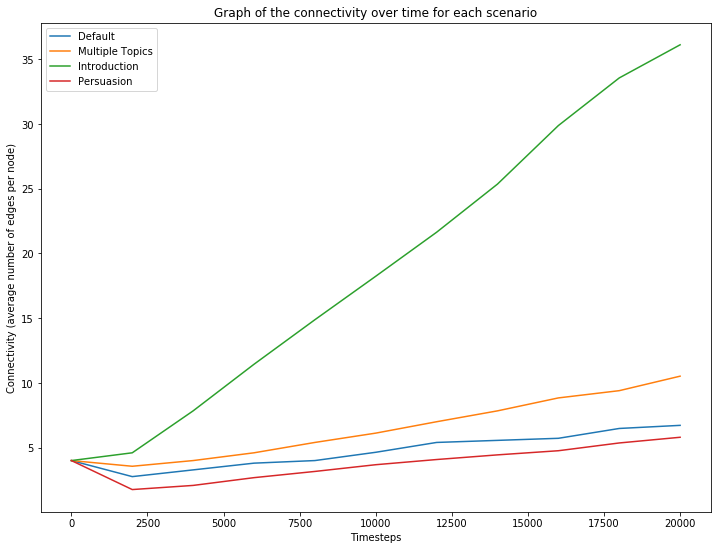

In [13]:
'''
Graph that shows the average number of connections per node 
over time for each of the 4 models above
'''
plt.figure(figsize=(12,9)) # Creating the figure
x = np.linspace(0, 20000, 11) # Creating the x-axis

# Plotting the results for each of the four scenarios above and labeling them
plt.plot(x, default_ave_connectivity, label="Default")
plt.plot(x, multiTopics_ave_connectivity, label="Multiple Topics")
plt.plot(x, introduction_ave_connectivity, label="Introduction")
plt.plot(x, uniquePersuasion_ave_connectivity, label="Persuasion")

# Adding x-, y-lables, title, legend, and show the graph
plt.xlabel("Timesteps")
plt.ylabel("Connectivity (average number of edges per node)")
plt.title("Graph of the connectivity over time for each scenario")
plt.legend()
plt.show()

I will also be plotting a graph that shows the number of disconnected nodes in the graph as the time passes for each of the 4 models above. This will be helpful when trying to determine whether if isolated clusters formed in the various scenarios that I outlined above.

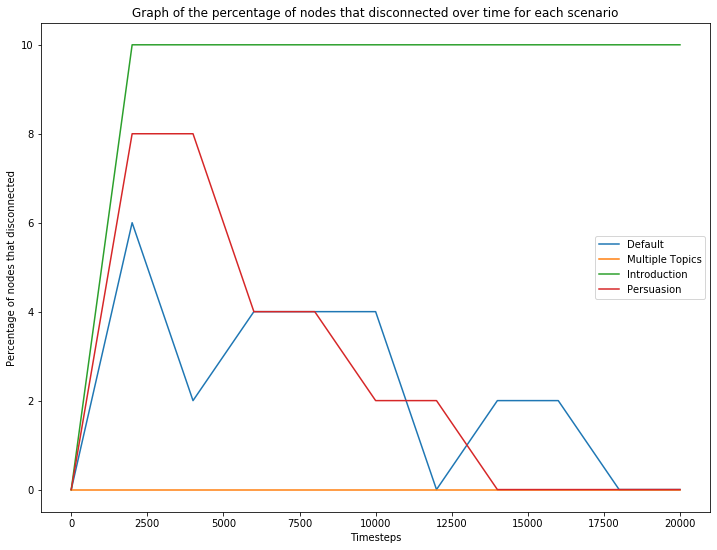

In [14]:
'''
Graph that shows the number of disconnected nodes in the graph 
over time for each of the 4 models above.
'''
plt.figure(figsize=(12,9)) # Creating the figure
x = np.linspace(0, 20000, 11) # Creating the x-axis

# Plotting the results for each of the four scenarios above and labeling them
plt.plot(x, default_disconnect, label="Default")
plt.plot(x, multiTopics_disconnect, label="Multiple Topics")
plt.plot(x, introduction_disconnect, label="Introduction")
plt.plot(x, uniquePersuasion_disconnect, label="Persuasion")

# Adding x-, y-lables, title, legend, and show the graph
plt.xlabel("Timesteps")
plt.ylabel("Percentage of nodes that disconnected")
plt.title("Graph of the percentage of nodes that disconnected over time for each scenario")
plt.legend()
plt.show()

### **Default Model**
For the default model, we notice that clustering did occur, with two clusters with very distinct opinions (as shown by the contrasting green and purple colors) forming after t=10,000. We also observe that the connectivity of the graph in terms of the average edges per node decerases in the beginning but then increases back to its original value. Also, in terms of the percentage of nodes that got disconnected, we notice that the default model has the second lowest number of disconnected nodes, which eventually get reconnected to the main graphs due to the random generation of new connections. This is a good representation of social interaction in real life because it shows the formation of new relationships, the weakening of existing relationships, and the eventual break in the relationship when it is too weak. However, this model can be improved to account for more human-like characteristics such as the capacity to have different opinions of different topics, to have different levels of persuasiveness, etc. 

### **Multiple Topics**
For this model, we notice that the graph gets really complex in the end due to the formation of new connections over time. Also, there were no isolated clusters at all, with all of the nodes sharing the same *average opinion* - here, I say "average" because the opinion value of each node is determined by getting the average of the opinions that the node has on all of the topics. Therefore, it makes sense that clustering didn't occur because whilst you might disagree with someone about topic A, you might be agree with them on topic B and therefore the average of your opinions will be the same as theirs. Also, in the connectivity analysis graph, we notice that this model displayed the least amount of initial decrease in connectivity in the beginning and also displayed the highest level of connectivity at the end compared to the default and persuasion models. There were also no nodes that got disconnected in this graph throughout all of the 20,000 timesteps. This is a better representation of society, especially within a close-knit community such as Minerva. Think about it, when you disagree on a subject with another person in Minerva, do you break the relationship right away? No! Even though I have different viewpoints on a certain topic with my best friends, we are still best friends because we agree on a variety of other topics and that balances out the disagreement.

### **Introduction Model**
This is by far the most interesting one out of all 4 of these scenarios. From the simulation above, we see a really bizarre pattern that starts to transpire even at t=2,000, the very first timestep marker. We notice that while the graph begins to break off, more connections begin to form between the nodes in the connected clusters. However, unlike the other graphs, reconnection to these isolated nodes do not occur, and at the end of the 20,000 timesteps, 10% of the nodes are disconnected (5 nodes out of the 50 nodes in the network). This makes sense, because introduction only happens when you are already connected to another person in the first place, and therefore if you are an isolated node, there is no way for you to be reintroduced to the main network. This reminds me of the movie Captain Fantastic, which is about two parents who raise their children in an isolated society of their own and away from the clutches of the modern world. As a result, the children had a lot of difficulty when trying to reconnect back to society when they needed to later on. To relate this to a more relatable context, just imagine scenarios where the introduction into a fraternity or sorirty is invite-only, and you can only get invited if you know someone on the inside. In this case, if you have no way to get to know someone on the inside, there is no way for you to be invited into the frat/sorority. However, on the flipside, this model has the highest connectivity out of all the other models - at nearly 4 times the connectivity of its closest competitor. This makes sense, since the more selective and prestigious a community is, the more tight knit they are (*cough* Minerva *cough*).

### **Persuasion Model**
This model is very similar to the default model in the sense that there was a formation of two distinct clusters, and the connectivity also decreased in the beginning and worked its way back up to its original value - it did drop a little more in the beginning though, which makes sense, because there could've been node pairings where there was an extreme difference in persuasion levels, which could've resulted in the connections breaking much quicker. This is also backed up by the second analysis which shows that there were more nodes that were separated from the main graph in the beginning, but they quickly reconnected and there were no isolated nodes in the end. This scenario is a better representation of real life compared to the default model, as it accounts for the varying levels of persuasion amongst different individuals in a social group. 

# **HCs Used**

## **#modelling**

In this assignment, I effectively developed a social dynamics simulation model in order to simulate the various scenarios given in the assignment instructions and provided clear, detailed explanations for all of them. I also accurately interprets and clearly explains the results of the model and how that relates to a real-life context.

## **#emergentproperties**

In this assignment, I effectively identified the various emergent properties that arose from the 4 different scenarios that I created by observing the output of the simulation and tied that back to the mechanics of the simulation to provide appropriate reasons and justifications for them.

## **#networks**

In this assignment, I analyzed the network structure of the social dynamics simulation model that I created in relation to the different scenarios at hand. I also used network analysis to propose effective interventions within a system by relating it back to a real-world context and see how the various scenarios that I created could model something that could happen in real life.